In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from torchmetrics.classification import Accuracy
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## TP3: Reconnaissance de signaux de communication par apprentissage profond


<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

3 séances de TP sur ce sujet : le 15 novembre (1h00), le 22 novembre (3h) et le 29 novembre (3h).<br>
Deadline : 6 décembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [2]:
data_path = 'samples.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [3]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

### Taille des données

In [4]:
data_path_train = 'train.hdf5'

data_train = h5py.File(data_path_train , 'r')

signals_train = np.array(data_train['signaux'])
snr_train =  np.array(data_train['snr'])
labels_id_train = np.array(data_train['labels'])
modulations_type = get_labels(data_train)

data_train.close()

In [5]:
data_path_validation = 'validation.hdf5'

data_validation = h5py.File(data_path_validation , 'r')

signals_validation = np.array(data_validation['signaux'])
snr_validation =  np.array(data_validation['snr'])
labels_id_validation = np.array(data_validation['labels'])

data_validation.close()

In [6]:
data_path_test = 'test.hdf5'

data_test = h5py.File(data_path_test , 'r')

signals_test = np.array(data_test['signaux'])
snr_test =  np.array(data_test['snr'])
labels_id_test = np.array(data_test['labels'])

data_test.close()

In [7]:
print('Shape of signals_train:', signals_train.shape)
print('Shape of snr_train:', snr_train.shape)
print('Shape of labels_id_train', labels_id_train.shape)

Shape of signals_train: (30000, 2048, 2)
Shape of snr_train: (30000,)
Shape of labels_id_train (30000,)


In [8]:
print('Shape of signals_validation:', signals_validation.shape)
print('Shape of snr_validation:', snr_validation.shape)
print('Shape of labels_id_validation', labels_id_validation.shape)

Shape of signals_validation: (10000, 2048, 2)
Shape of snr_validation: (10000,)
Shape of labels_id_validation (10000,)


### Distribution des classes dans l'ensemble d'entraînement

In [9]:
unique = np.unique(labels_id_train)
print("Unique values in labels_id_train:", unique)

Unique values in labels_id_train: [0 1 2 3 4 5]


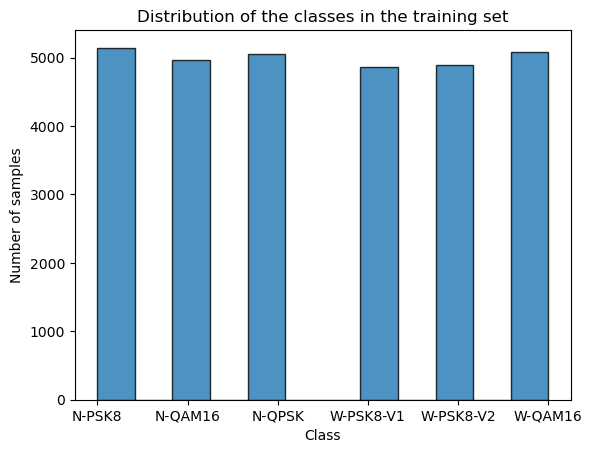

In [10]:
plt.hist(labels_id_train, bins=12, alpha=0.8, edgecolor = 'black')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(range(len(list(modulations_type.values()))), list(modulations_type.values()))
plt.title('Distribution of the classes in the training set')
plt.show()

### Distribution des SNR dans le l'ensemble d'entraînement

In [11]:
unique = np.unique(snr_train)
print("Unique values in snr_train:", unique)

Unique values in snr_train: [ 0 10 20 30]


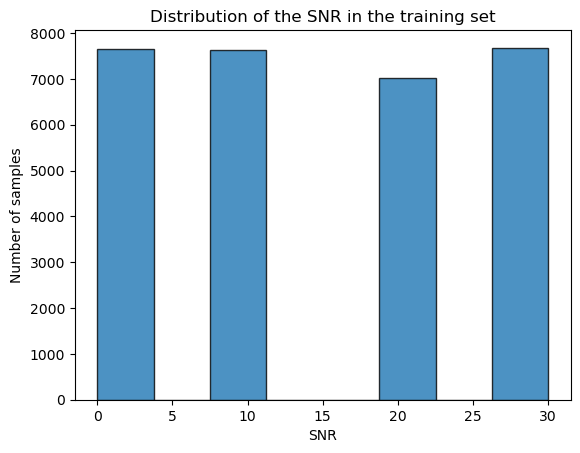

In [12]:
plt.hist(snr_train, bins=8, alpha=0.8, edgecolor = 'black')
plt.xlabel('SNR')
plt.ylabel('Number of samples')
plt.title('Distribution of the SNR in the training set')
plt.show()

### Visualisation des signaux

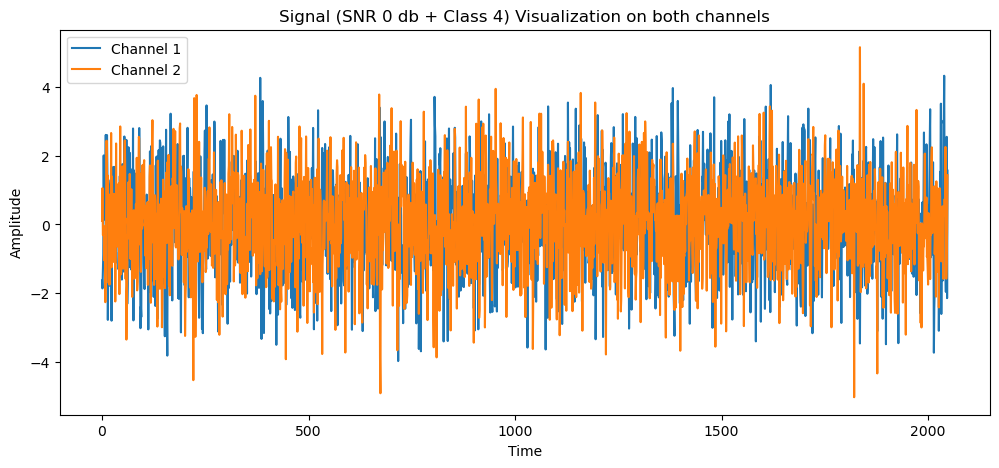

In [13]:
signal_to_visualize_channel_1 = signals_train[0, :, 0]
signal_to_visualize_channel_2 = signals_train[0, :, 1]
plt.figure(figsize=(12,5))
plt.plot(signal_to_visualize_channel_1, label='Channel 1')
plt.plot(signal_to_visualize_channel_2, label='Channel 2')
plt.title('Signal (SNR 0 db + Class 4) Visualization on both channels')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

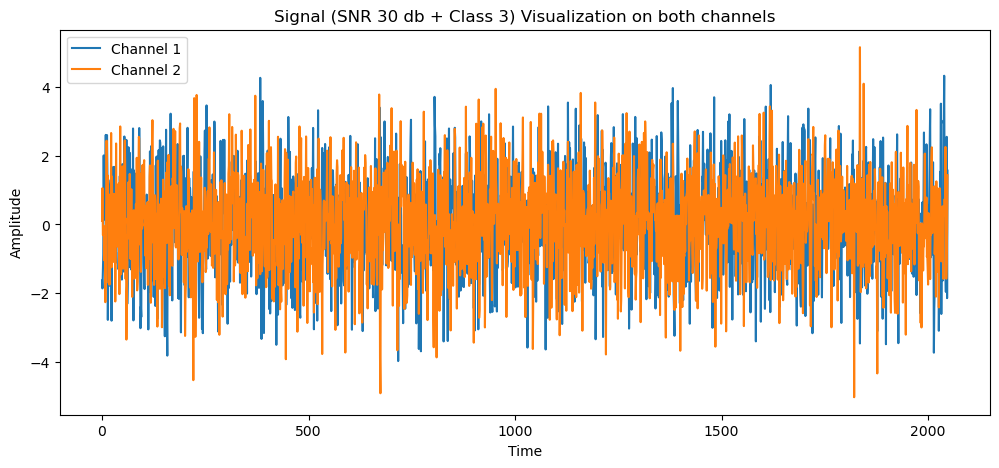

In [14]:
signal_to_visualize_channel_1 = signals_train[0, :, 0]
signal_to_visualize_channel_2 = signals_train[0, :, 1]
plt.figure(figsize=(12,5))
plt.plot(signal_to_visualize_channel_1, label='Channel 1')
plt.plot(signal_to_visualize_channel_2, label='Channel 2')
plt.title('Signal (SNR 30 db + Class 3) Visualization on both channels')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## Chargement des données en PyTorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un Dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [15]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path, device='cpu'):
        data = h5py.File(path , 'r')
        self.signals = np.array(data['signaux'])
        self.snr = np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        data.close()
        self.device = device

    def __len__(self):
        return self.snr.shape[0]

    def __getitem__(self, idx):
        return self.signals[idx], self.labels_id[idx], self.snr[idx]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [16]:
sample_dataset = MyDataset("samples.hdf5")
train_dataset = MyDataset("train.hdf5")
validation_dataset = MyDataset("validation.hdf5")
test_dataset = MyDataset("test.hdf5")

In [17]:
sample_dataloader = DataLoader(sample_dataset, batch_size=10, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Testez le dataloader pour différentes valeurs de batch_size

In [18]:
print(f"Testing with batch_size = {10}:\n")

for batch in sample_dataloader:
    signals_batch, labels_id_batch, snrs_batch = batch
    print(f"Signal Batch Shape: {signals_batch.shape}")
    print(f"Labels Batch: {labels_id_batch}")
    print(f"SNRs Batch: {snrs_batch}")
    print("-" * 90)

Testing with batch_size = 10:

Signal Batch Shape: torch.Size([10, 2048, 2])
Labels Batch: tensor([4, 5, 3, 0, 0, 4, 0, 3, 3, 4], dtype=torch.int8)
SNRs Batch: tensor([20, 30, 20, 10, 10, 10, 10, 30, 20, 20], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([10, 2048, 2])
Labels Batch: tensor([1, 0, 0, 2, 3, 3, 0, 5, 3, 0], dtype=torch.int8)
SNRs Batch: tensor([10, 20,  0, 10, 20, 10, 30, 10,  0,  0], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([10, 2048, 2])
Labels Batch: tensor([0, 4, 5, 3, 5, 5, 2, 1, 2, 1], dtype=torch.int8)
SNRs Batch: tensor([30, 30, 30, 30, 10, 10,  0, 30, 10, 30], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([10, 2048, 2])
Labels Batch: tensor([0, 2, 5, 0, 1, 0, 3, 4, 1, 4], dtype=

In [19]:
sample_dataloader = DataLoader(sample_dataset, batch_size=5, shuffle=True)

print(f"Testing with batch_size = {5}:\n")

for batch in sample_dataloader:
    signals_batch, labels_id_batch, snrs_batch = batch
    print(f"Signal Batch Shape: {signals_batch.shape}")
    print(f"Labels Batch: {labels_id_batch}")
    print(f"Snrs Batch: {snrs_batch}")
    print("-" * 90)

Testing with batch_size = 5:

Signal Batch Shape: torch.Size([5, 2048, 2])
Labels Batch: tensor([3, 0, 1, 1, 3], dtype=torch.int8)
Snrs Batch: tensor([20, 10, 30, 10, 30], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([5, 2048, 2])
Labels Batch: tensor([4, 1, 5, 0, 3], dtype=torch.int8)
Snrs Batch: tensor([10, 10, 10, 30, 10], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([5, 2048, 2])
Labels Batch: tensor([2, 5, 3, 3, 4], dtype=torch.int8)
Snrs Batch: tensor([10,  0, 30, 10, 30], dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([5, 2048, 2])
Labels Batch: tensor([2, 1, 3, 3, 1], dtype=torch.int8)
Snrs Batch: tensor([30, 10, 30, 20, 10], dtype=torch.int16)
-----------------------------------------------------

In [20]:
sample_dataloader = DataLoader(sample_dataset, batch_size=15, shuffle=True)

print(f"Testing with batch_size = {15}:\n")

for batch in sample_dataloader:
    signals_batch, labels_id_batch, snrs_batch = batch
    print(f"Signal Batch Shape: {signals_batch.shape}")
    print(f"Labels Batch: {labels_id_batch}")
    print(f"Snrs Batch: {snrs_batch}")
    print("-" * 90)

Testing with batch_size = 15:

Signal Batch Shape: torch.Size([15, 2048, 2])
Labels Batch: tensor([5, 5, 1, 5, 1, 4, 4, 1, 5, 2, 1, 3, 4, 2, 1], dtype=torch.int8)
Snrs Batch: tensor([ 0, 10, 30, 10, 30, 10, 30, 10, 10, 10, 30, 30, 10,  0, 30],
       dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Labels Batch: tensor([3, 4, 2, 1, 5, 3, 4, 5, 3, 0, 1, 5, 3, 1, 5], dtype=torch.int8)
Snrs Batch: tensor([10, 20, 10, 30, 30, 10, 30, 10, 30, 30,  0, 10,  0, 20, 20],
       dtype=torch.int16)
------------------------------------------------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Labels Batch: tensor([2, 0, 5, 2, 2, 0, 4, 2, 4, 3, 2, 0, 3, 2, 4], dtype=torch.int8)
Snrs Batch: tensor([ 0, 10, 30, 30, 10, 30, 10, 10, 10, 10, 10, 20, 30, 10, 10],
       dtype=torch.int16)
----------------------------------------------------------------------

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [21]:
class DumbModel(nn.Module):
    def __init__(self):
        super(DumbModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(1000, 6)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = x[:, :1000]
        x = self.fc(x)
        x = self.softmax(x)
        return x

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées

In [22]:
model = DumbModel()

for batch in sample_dataloader:
    signals_batch, labels_id_batch, snrs_batch = batch
    print(f"Signal Batch Shape: {signals_batch.shape}")
    print(f"Output Batch Shape: {model(signals_batch.float()).shape}")
    print(f"Snrs Batch Shape: {snrs_batch.shape}")
    print("-" * 50)

Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
--------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
--------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
--------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
--------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
--------------------------------------------------
Signal Batch Shape: torch.Size([15, 2048, 2])
Output Batch Shape: torch.Size([15, 6])
Snrs Batch Shape: torch.Size([15])
-------------------

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [23]:
criterion = nn.NLLLoss()
n_epochs = 10
device = 'cpu'
model = model
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
print('The number of parameters of the Dumb Model is', sum(p.numel() for p in model.parameters()))

The number of parameters of the Dumb Model is 6006


In [24]:
def test_acc(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = correct / total
    return accuracy

In [25]:
def train_pipeline(model, n_epochs):
    for epoch in range(n_epochs):

        model.train()
        with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch') as pbar_train:
            for _, (batch_x, batch_y, _) in enumerate(train_dataloader):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                optimizer.zero_grad()

                pred_y = model(batch_x)
                loss = criterion(pred_y, batch_y.long())
                loss.backward()
                optimizer.step()

                pbar_train.update(1)
                pbar_train.set_postfix(train_loss=f'{loss.item():.4f}')

        model.eval()
        with tqdm(total=len(validation_dataloader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch') as pbar_val:
            with torch.no_grad():
                total_correct = 0
                total = 0
                for _, (batch_x, batch_y, _) in enumerate(validation_dataloader):
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    pred_y = model(batch_x)
                    loss = criterion(pred_y, batch_y.long())

                    _, predicted = torch.max(pred_y.data, 1)
                    total_correct += (predicted == batch_y).sum().item()
                    total += batch_y.size(0)

                    pbar_val.update(1)
                    pbar_val.set_postfix(val_loss=f'{loss.item():.4f}')
                    pbar_val.set_postfix(val_acc=f'{total_correct / total:.4f}')
        
        print(f'Epoch {epoch + 1}/{n_epochs}: Validation Loss: {loss.item():.4f} | Validation Accuracy: {total_correct / total:.4f}')

In [26]:
train_pipeline(model, n_epochs)

Epoch 1/10: 100%|██████████| 157/157 [00:00<00:00, 292.52batch/s, val_acc=0.1768] 


Epoch 1/10: Validation Loss: 1.9243 | Validation Accuracy: 0.1768


Epoch 2/10: 100%|██████████| 157/157 [00:00<00:00, 285.56batch/s, val_acc=0.1787] 


Epoch 2/10: Validation Loss: 1.8356 | Validation Accuracy: 0.1787


Epoch 3/10: 100%|██████████| 157/157 [00:00<00:00, 280.61batch/s, val_acc=0.1759] 


Epoch 3/10: Validation Loss: 1.6955 | Validation Accuracy: 0.1759


Epoch 4/10: 100%|██████████| 157/157 [00:00<00:00, 293.06batch/s, val_acc=0.1769] 


Epoch 4/10: Validation Loss: 2.0274 | Validation Accuracy: 0.1769


Epoch 5/10: 100%|██████████| 157/157 [00:00<00:00, 292.99batch/s, val_acc=0.1770] 


Epoch 5/10: Validation Loss: 2.0255 | Validation Accuracy: 0.1770


Epoch 6/10: 100%|██████████| 157/157 [00:00<00:00, 295.71batch/s, val_acc=0.1749] 


Epoch 6/10: Validation Loss: 1.9013 | Validation Accuracy: 0.1749


Epoch 7/10: 100%|██████████| 157/157 [00:00<00:00, 292.62batch/s, val_acc=0.1806] 


Epoch 7/10: Validation Loss: 1.8072 | Validation Accuracy: 0.1806


Epoch 8/10: 100%|██████████| 157/157 [00:00<00:00, 298.72batch/s, val_acc=0.1754] 


Epoch 8/10: Validation Loss: 1.7751 | Validation Accuracy: 0.1754


Epoch 9/10: 100%|██████████| 157/157 [00:00<00:00, 297.83batch/s, val_acc=0.1753] 


Epoch 9/10: Validation Loss: 1.9123 | Validation Accuracy: 0.1753


Epoch 10/10: 100%|██████████| 157/157 [00:00<00:00, 311.11batch/s, val_acc=0.1759] 

Epoch 10/10: Validation Loss: 1.7809 | Validation Accuracy: 0.1759


In [27]:
torch.save(model, "dumb_model.pt")

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [28]:
def test_pipeline(model):
    accuracy_metric = Accuracy(task='multiclass', num_classes=6)
    model.eval()

    all_predictions = []
    all_labels = []
    all_snrs = []
    accuracies = []

    with torch.no_grad():
        with tqdm(total=len(test_dataloader), desc=f'Running test', unit='batch') as pbar_test:
            for batch_x, batch_y, batch_snr in test_dataloader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                batch_y_predicted = model(batch_x)
                loss = criterion(batch_y_predicted, batch_y.long())

                all_predictions.append(batch_y_predicted)
                all_labels.append(batch_y)
                all_snrs.append(batch_snr)

                pbar_test.update(1)
                pbar_test.set_postfix(test_loss=f'{loss.item():.4f}')

        all_predictions = torch.cat(all_predictions, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        all_snrs = torch.cat(all_snrs, dim=0)

        _, predicted_labels = torch.max(all_predictions, 1)

        _, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

        for i, snr in enumerate(np.unique(all_snrs)):
            idx = torch.where(all_snrs == snr)
            pred = predicted_labels[idx]
            lab = all_labels[idx]
            cm = confusion_matrix(lab.cpu(), pred.cpu())
            accuracies.append(accuracy_metric(pred.cpu(), lab.cpu()))

            ax = axes[i // 2, i % 2]
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
            ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
            ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
            ax.set_title(f"Confusion Matrix for the Dumb Model for SNR={snr}")

        plt.tight_layout()
        plt.figure(figsize=(15, 5))
        plt.plot([0, 10, 20, 30], accuracies, marker='o')
        plt.xlabel("SNR")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs SNR for the Dumb Model")
        plt.tight_layout()
        plt.show()

Running test: 100%|██████████| 157/157 [00:00<00:00, 454.29batch/s, test_loss=2.0197]


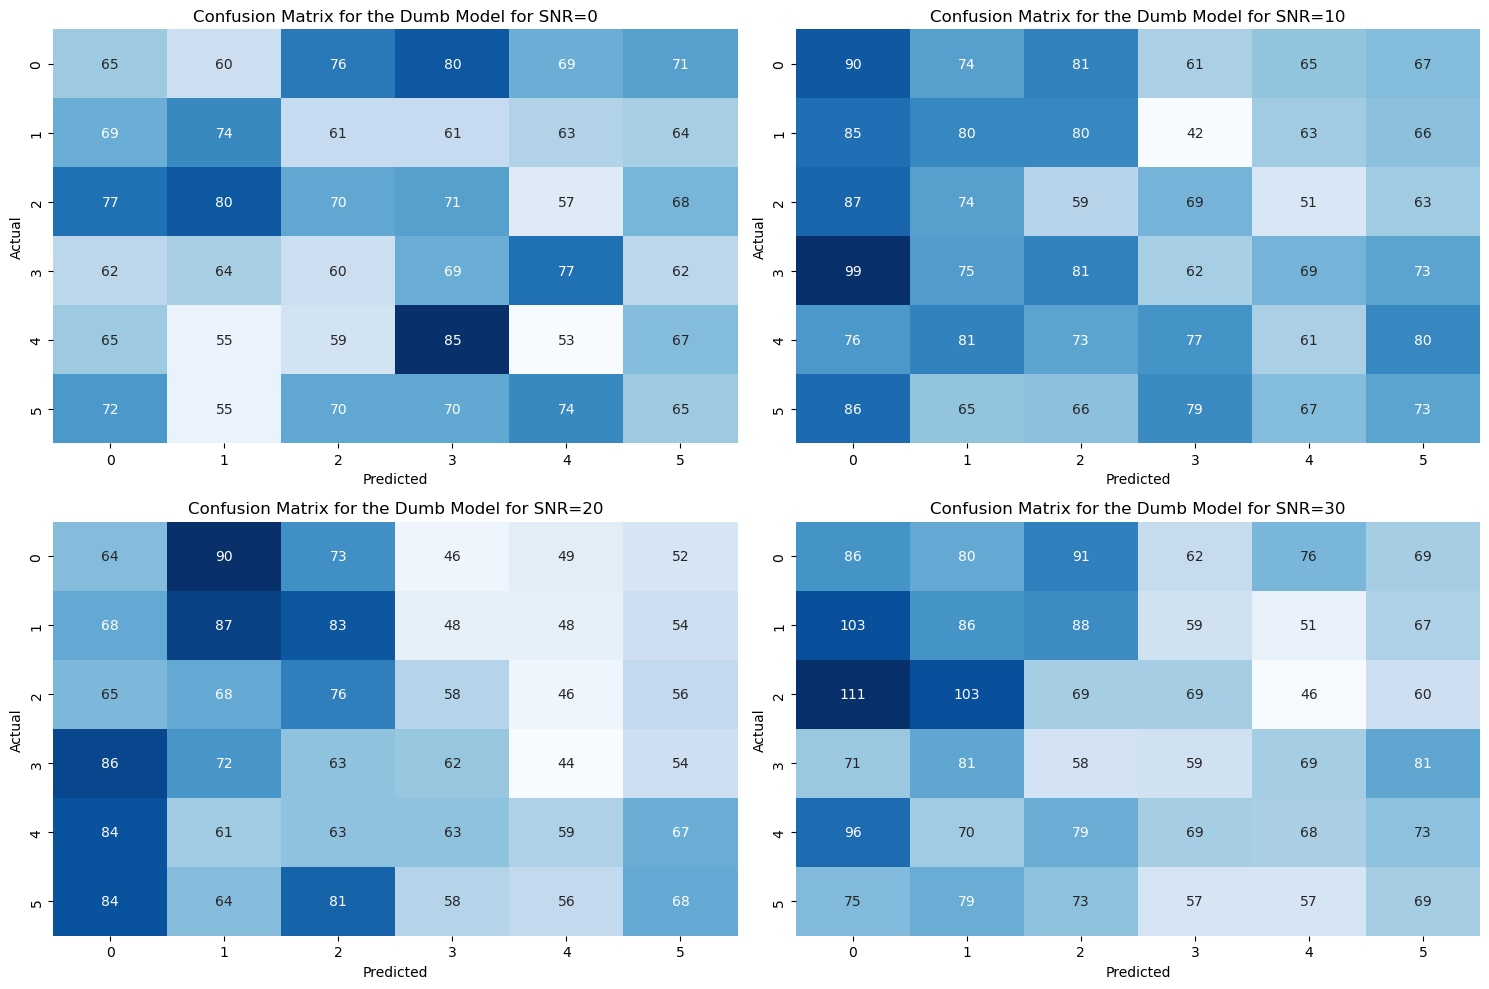

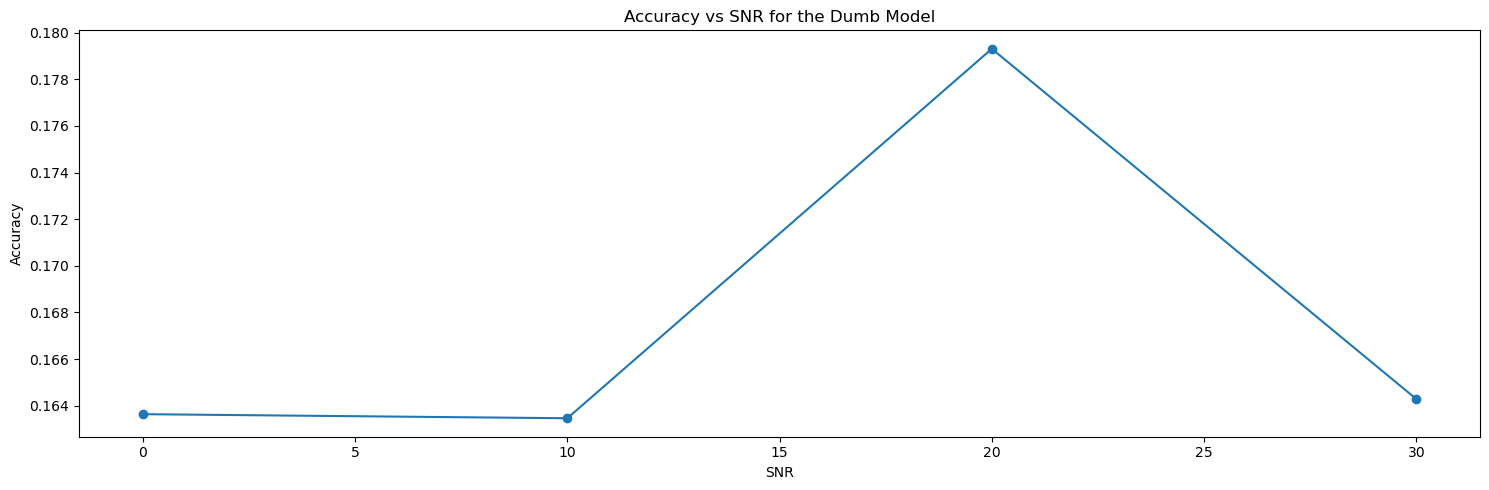

In [29]:
model = torch.load("dumb_model.pt")
test_pipeline(model)

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Vous pouvez si vous le souhaitez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=16)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(64 * 128, 6)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x

In [31]:
criterion = nn.NLLLoss()
n_epochs = 10
model_cnn = CNN()
model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters())
print('The number of parameters of the CNN Model is', sum(p.numel() for p in model_cnn.parameters()))

The number of parameters of the CNN Model is 49606


In [32]:
train_pipeline(model_cnn, n_epochs)
torch.save(model_cnn, "cnn_model.pt")

Epoch 1/10: 100%|██████████| 157/157 [00:05<00:00, 31.19batch/s, val_acc=0.3748] 


Epoch 1/10: Validation Loss: 1.1381 | Validation Accuracy: 0.3748


Epoch 2/10: 100%|██████████| 157/157 [00:05<00:00, 30.96batch/s, val_acc=0.5513] 


Epoch 2/10: Validation Loss: 0.9493 | Validation Accuracy: 0.5513


Epoch 3/10: 100%|██████████| 157/157 [00:05<00:00, 29.26batch/s, val_acc=0.5448] 


Epoch 3/10: Validation Loss: 0.7442 | Validation Accuracy: 0.5448


Epoch 4/10: 100%|██████████| 157/157 [00:05<00:00, 31.01batch/s, val_acc=0.5596] 


Epoch 4/10: Validation Loss: 0.8444 | Validation Accuracy: 0.5596


Epoch 5/10: 100%|██████████| 157/157 [00:04<00:00, 31.79batch/s, val_acc=0.5611] 


Epoch 5/10: Validation Loss: 1.1128 | Validation Accuracy: 0.5611


Epoch 6/10: 100%|██████████| 157/157 [00:05<00:00, 30.83batch/s, val_acc=0.5586] 


Epoch 6/10: Validation Loss: 1.1441 | Validation Accuracy: 0.5586


Epoch 7/10: 100%|██████████| 157/157 [00:04<00:00, 32.81batch/s, val_acc=0.5673] 


Epoch 7/10: Validation Loss: 0.7673 | Validation Accuracy: 0.5673


Epoch 8/10: 100%|██████████| 157/157 [00:04<00:00, 32.47batch/s, val_acc=0.5570] 


Epoch 8/10: Validation Loss: 1.0436 | Validation Accuracy: 0.5570


Epoch 9/10: 100%|██████████| 157/157 [00:05<00:00, 30.44batch/s, val_acc=0.5880] 


Epoch 9/10: Validation Loss: 1.0875 | Validation Accuracy: 0.5880


Epoch 10/10: 100%|██████████| 157/157 [00:04<00:00, 32.45batch/s, val_acc=0.5841] 

Epoch 10/10: Validation Loss: 0.9982 | Validation Accuracy: 0.5841


In [33]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(2048, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(64, 6)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x, _ = self.lstm(x.transpose(1, 2))
        x = torch.mean(x, dim=1)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x

In [34]:
criterion = nn.NLLLoss()
n_epochs = 10
model_cnn_lstm = CNN_LSTM()
model_cnn_lstm.to(device)
optimizer = torch.optim.Adam(model_cnn_lstm.parameters())
print('The number of parameters of the CNN Model is', sum(p.numel() for p in model_cnn_lstm.parameters()))

The number of parameters of the CNN Model is 836614


In [35]:
train_pipeline(model_cnn_lstm, n_epochs)
torch.save(model_cnn_lstm, "cnn_lstm_model.pt")

Epoch 1/10: 100%|██████████| 157/157 [00:01<00:00, 94.97batch/s, val_acc=0.2473] 


Epoch 1/10: Validation Loss: 1.5592 | Validation Accuracy: 0.2473


Epoch 2/10: 100%|██████████| 157/157 [00:01<00:00, 98.41batch/s, val_acc=0.2790] 


Epoch 2/10: Validation Loss: 1.3574 | Validation Accuracy: 0.2790


Epoch 3/10: 100%|██████████| 157/157 [00:01<00:00, 95.73batch/s, val_acc=0.2799] 


Epoch 3/10: Validation Loss: 2.1812 | Validation Accuracy: 0.2799


Epoch 4/10: 100%|██████████| 157/157 [00:01<00:00, 96.90batch/s, val_acc=0.2784] 


Epoch 4/10: Validation Loss: 1.5227 | Validation Accuracy: 0.2784


Epoch 5/10: 100%|██████████| 157/157 [00:01<00:00, 99.14batch/s, val_acc=0.2795]  


Epoch 5/10: Validation Loss: 1.5793 | Validation Accuracy: 0.2795


Epoch 6/10: 100%|██████████| 157/157 [00:01<00:00, 100.48batch/s, val_acc=0.2763] 


Epoch 6/10: Validation Loss: 1.5678 | Validation Accuracy: 0.2763


Epoch 7/10: 100%|██████████| 157/157 [00:01<00:00, 99.35batch/s, val_acc=0.2835]  


Epoch 7/10: Validation Loss: 1.9957 | Validation Accuracy: 0.2835


Epoch 8/10: 100%|██████████| 157/157 [00:01<00:00, 101.55batch/s, val_acc=0.2751] 


Epoch 8/10: Validation Loss: 3.0131 | Validation Accuracy: 0.2751


Epoch 9/10: 100%|██████████| 157/157 [00:01<00:00, 100.63batch/s, val_acc=0.2704] 


Epoch 9/10: Validation Loss: 2.3662 | Validation Accuracy: 0.2704


Epoch 10/10: 100%|██████████| 157/157 [00:01<00:00, 103.49batch/s, val_acc=0.2709] 

Epoch 10/10: Validation Loss: 2.8101 | Validation Accuracy: 0.2709


In [79]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(kernel_size=8)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(256 * 4, 6)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x

In [80]:
criterion = nn.NLLLoss()
n_epochs = 10
model_improved_cnn = ImprovedCNN()
model_improved_cnn.to(device)
optimizer = torch.optim.Adam(model_improved_cnn.parameters())
print('The number of parameters of the Improved CNN Model is', sum(p.numel() for p in model_improved_cnn.parameters()))

The number of parameters of the Improved CNN Model is 130758


In [81]:
train_pipeline(model_improved_cnn, n_epochs)
torch.save(model_improved_cnn, "improved_cnn_model.pt")

Epoch 1/10: 100%|██████████| 157/157 [00:08<00:00, 18.54batch/s, val_acc=0.6037] 


Epoch 1/10: Validation Loss: 0.5072 | Validation Accuracy: 0.6037


Epoch 2/10: 100%|██████████| 157/157 [00:08<00:00, 18.58batch/s, val_acc=0.5902] 


Epoch 2/10: Validation Loss: 0.6373 | Validation Accuracy: 0.5902


Epoch 3/10: 100%|██████████| 157/157 [00:07<00:00, 20.44batch/s, val_acc=0.6043] 


Epoch 3/10: Validation Loss: 0.8577 | Validation Accuracy: 0.6043


Epoch 4/10: 100%|██████████| 157/157 [00:07<00:00, 19.83batch/s, val_acc=0.7534] 


Epoch 4/10: Validation Loss: 0.5591 | Validation Accuracy: 0.7534


Epoch 5/10: 100%|██████████| 157/157 [00:08<00:00, 19.56batch/s, val_acc=0.7127] 


Epoch 5/10: Validation Loss: 0.5994 | Validation Accuracy: 0.7127


Epoch 6/10: 100%|██████████| 157/157 [00:07<00:00, 19.64batch/s, val_acc=0.8049] 


Epoch 6/10: Validation Loss: 0.2836 | Validation Accuracy: 0.8049


Epoch 7/10: 100%|██████████| 157/157 [00:08<00:00, 18.94batch/s, val_acc=0.8161] 


Epoch 7/10: Validation Loss: 0.4441 | Validation Accuracy: 0.8161


Epoch 8/10: 100%|██████████| 157/157 [00:08<00:00, 18.95batch/s, val_acc=0.7320] 


Epoch 8/10: Validation Loss: 0.2531 | Validation Accuracy: 0.7320


Epoch 9/10: 100%|██████████| 157/157 [00:08<00:00, 19.59batch/s, val_acc=0.8406] 


Epoch 9/10: Validation Loss: 0.1769 | Validation Accuracy: 0.8406


Epoch 10/10: 100%|██████████| 157/157 [00:08<00:00, 19.06batch/s, val_acc=0.8242] 

Epoch 10/10: Validation Loss: 0.2658 | Validation Accuracy: 0.8242


## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test

Running test: 100%|██████████| 157/157 [00:05<00:00, 30.82batch/s, test_loss=1.3053]


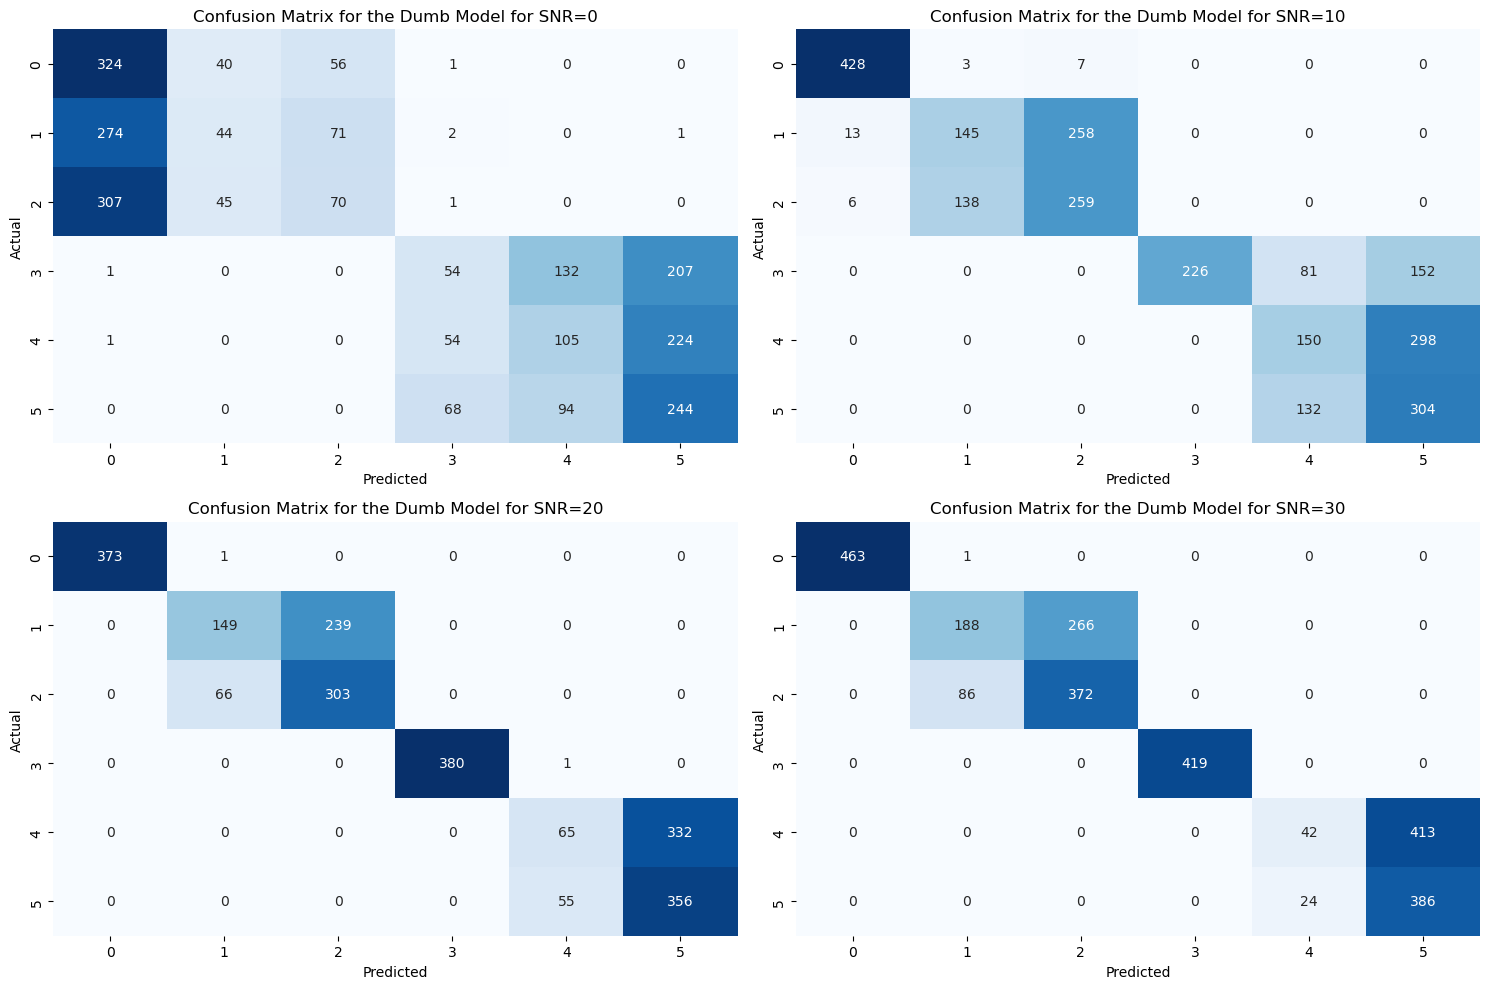

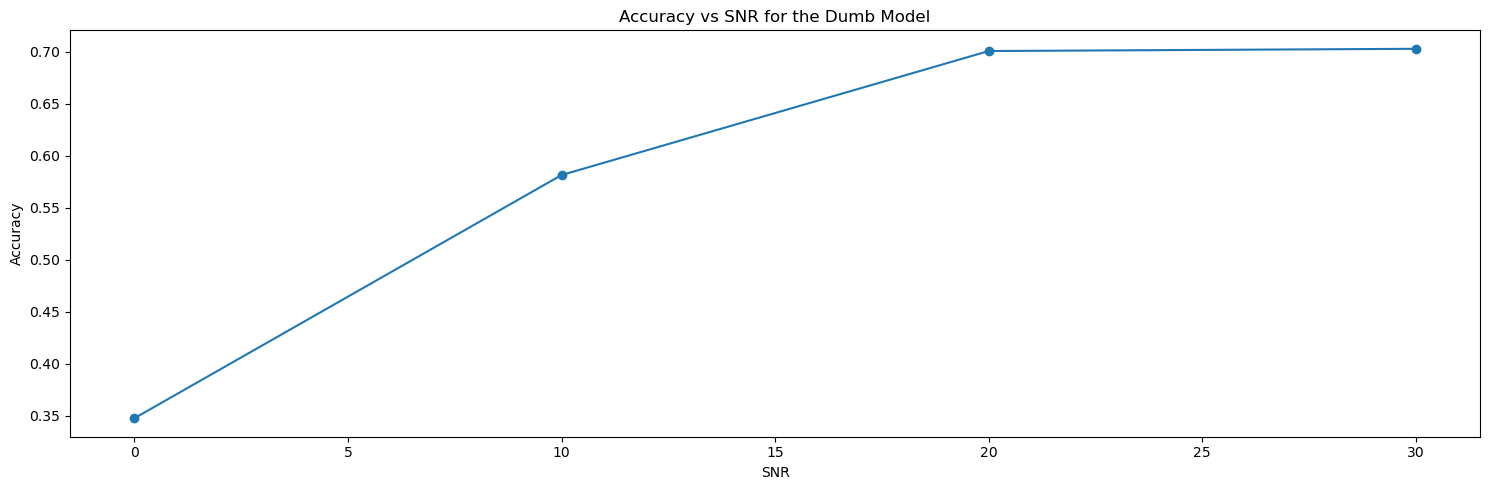

In [82]:
model_cnn = torch.load("cnn_model.pt")
test_pipeline(model_cnn)

Le CNN donne de meilleurs résultats que le Dumb Model, cependant il est beaucoup plus lent à entrainer et à évaluer.

Running test: 100%|██████████| 157/157 [00:01<00:00, 102.16batch/s, test_loss=3.3136]


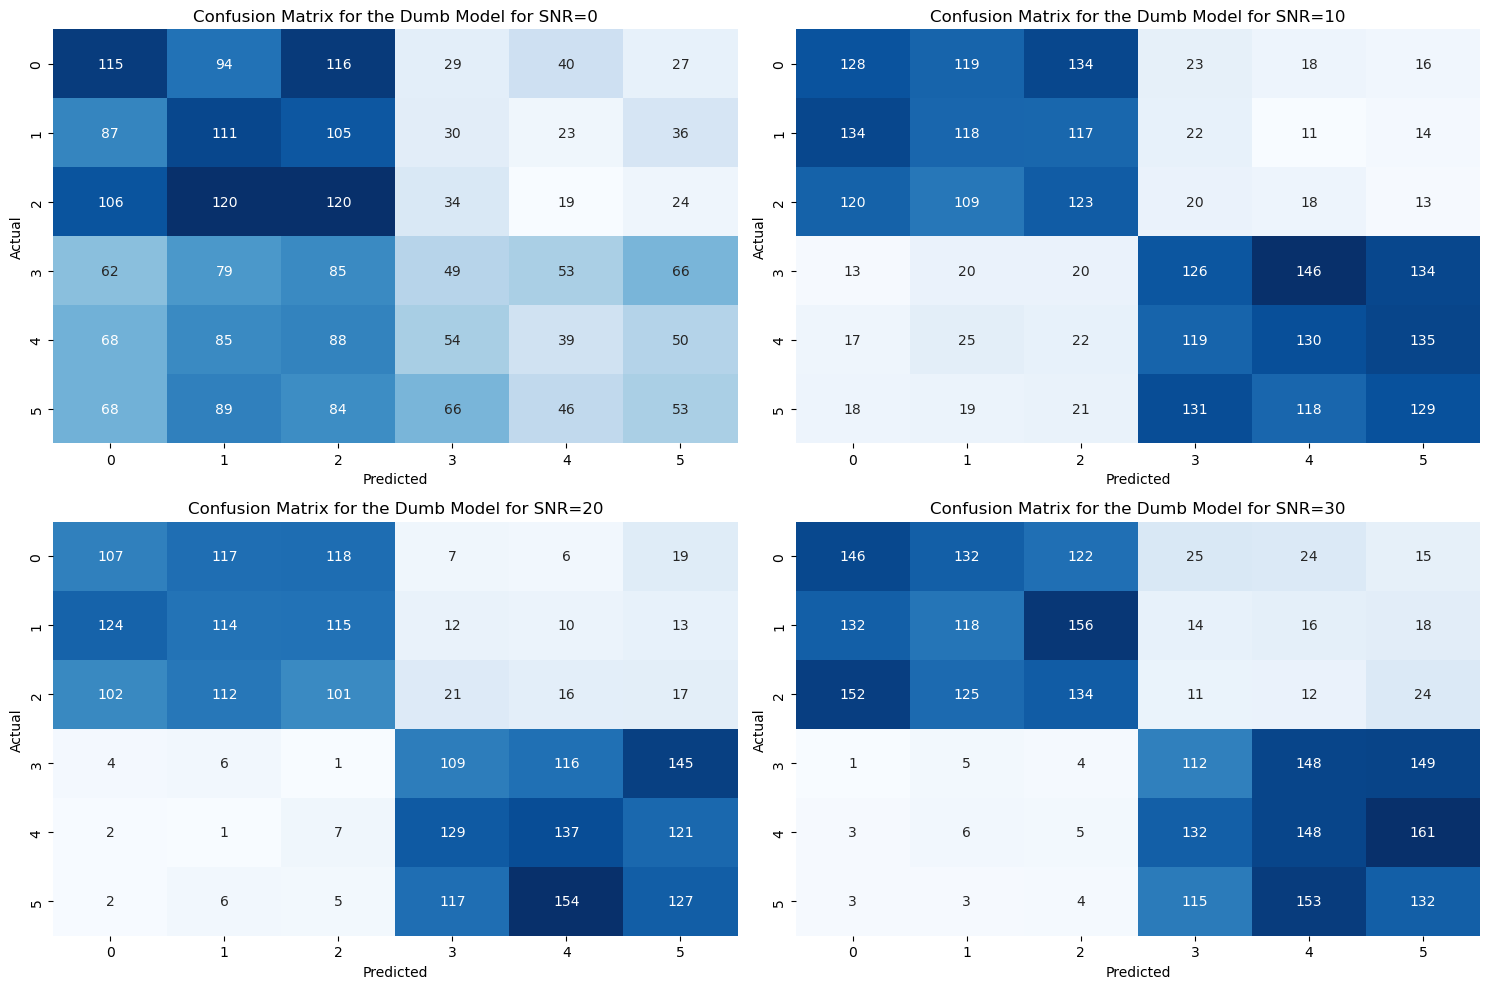

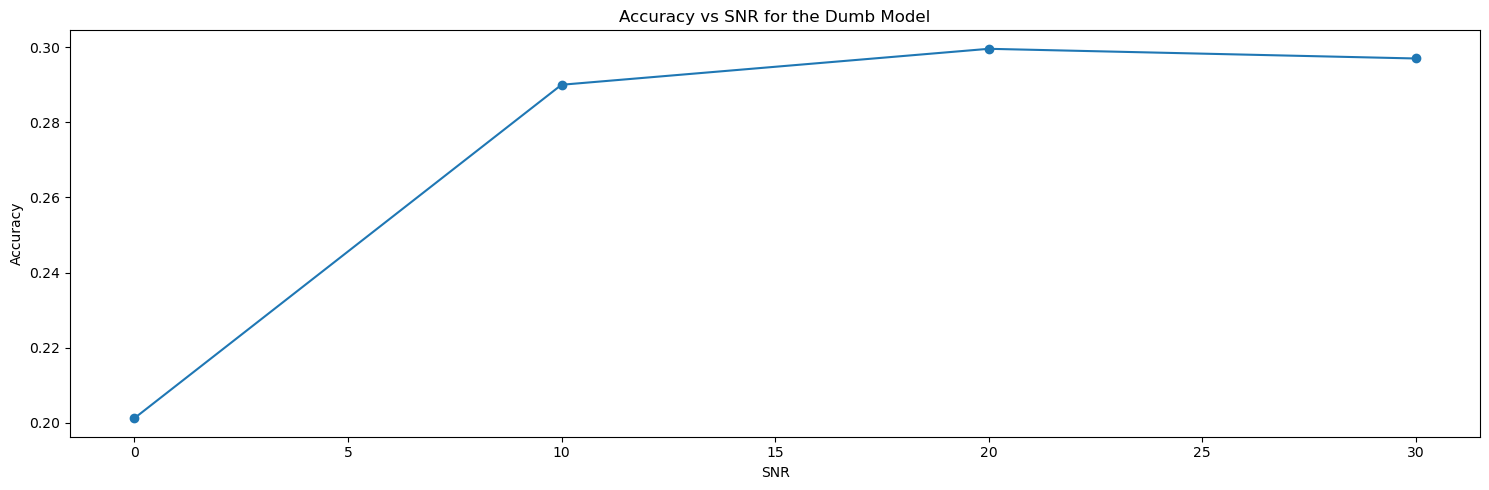

In [83]:
model_cnn_lstm = torch.load("cnn_lstm_model.pt")
test_pipeline(model_cnn_lstm)

Le LSTM n'arrive pas à dépasser les performances du CNN et reste bien en-dessous. On va donc se concentrer sur le CNN et essayer de l'améliorer.

Running test: 100%|██████████| 157/157 [00:08<00:00, 19.08batch/s, test_loss=0.2663]


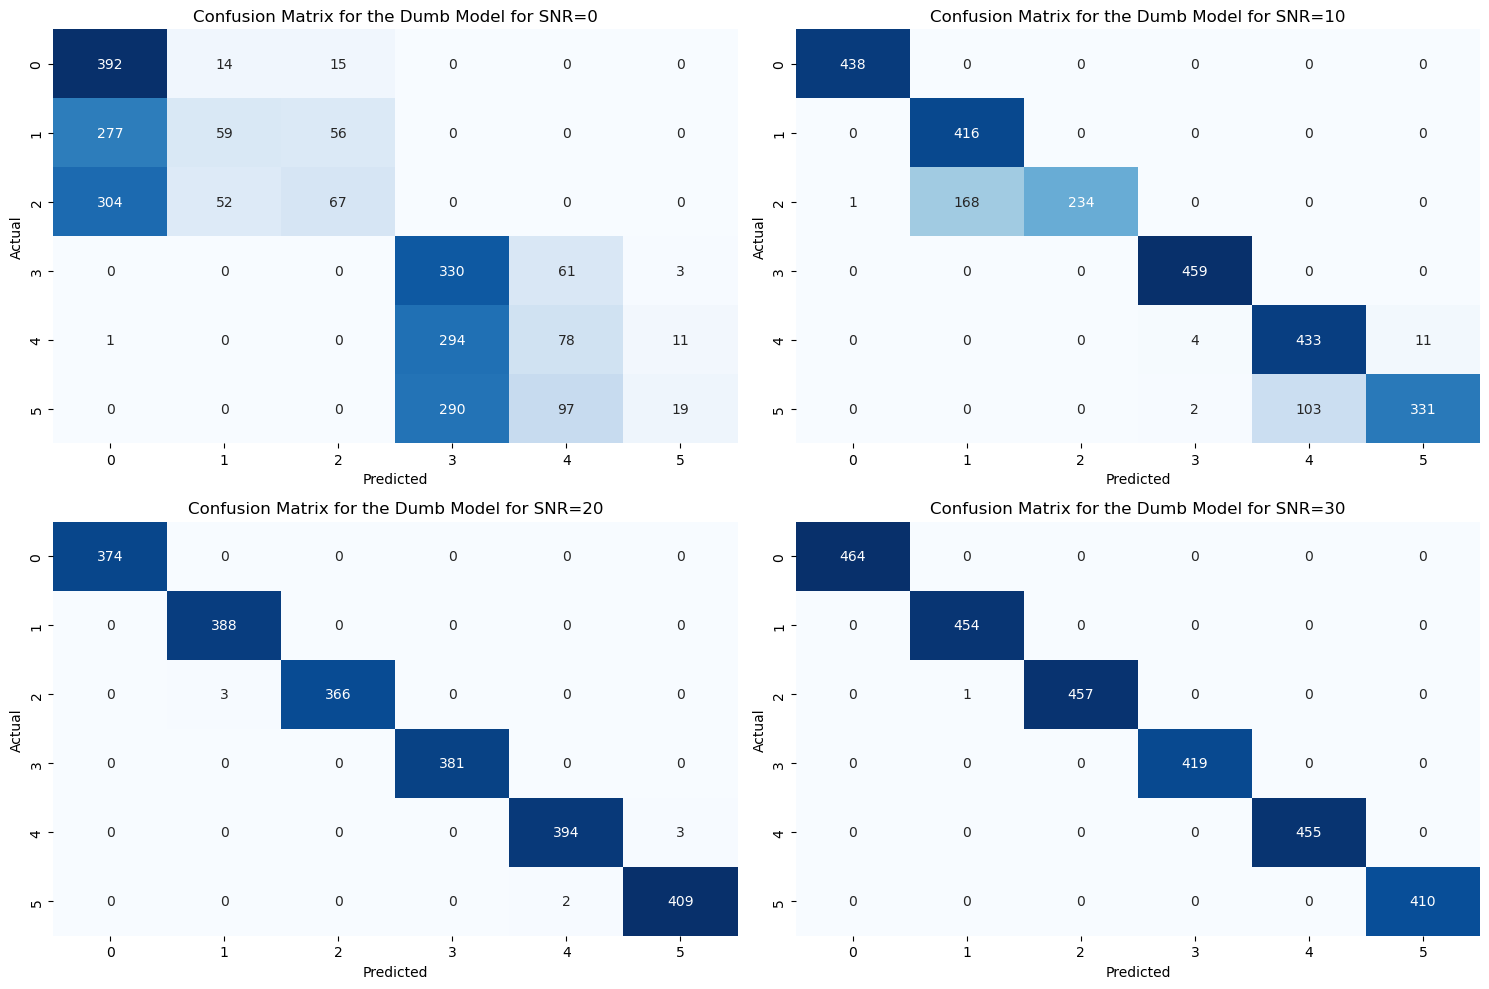

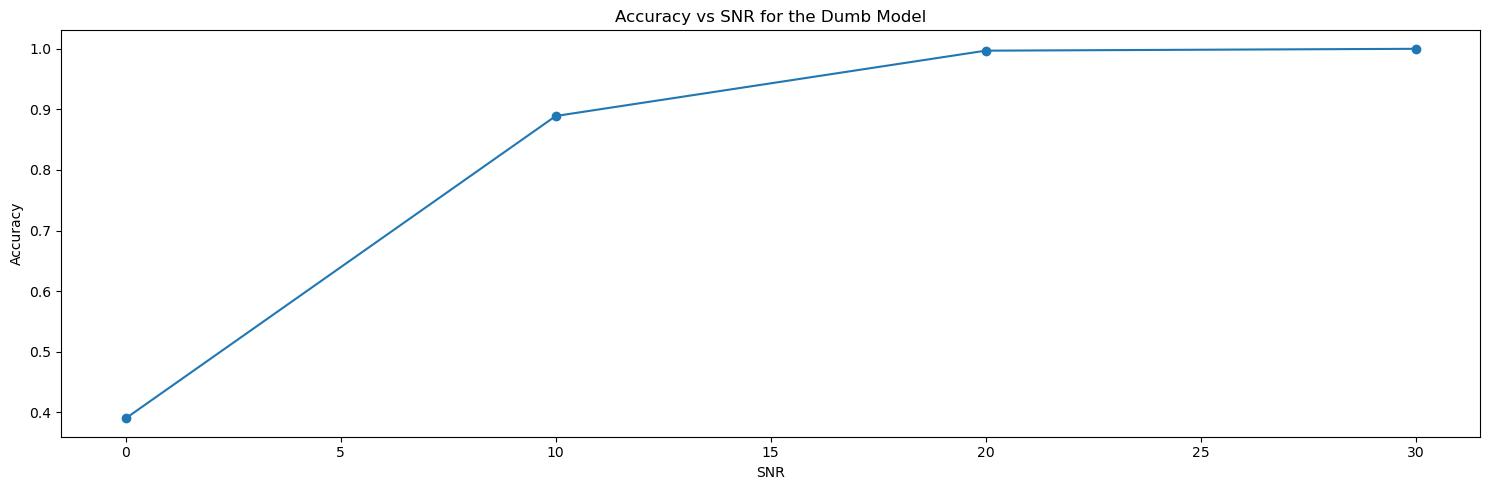

In [84]:
model_improved_cnn = torch.load("improved_cnn_model.pt")
test_pipeline(model_improved_cnn)

Le Improved CNN (CNN avec plus de couches et des batch normalization) donne de meilleurs résultats que le CNN mais il est encore plus lent à entrainer et à évaluer.

### Remarques Générales

Pour notre dernier modèle on arrive à obtenir des très bons résultats avec seulement 8 erreurs de prédiction pour SNR=20 et une seule erreur de prédiction pour SNR=30. Cependant, le modèle n'est pas aussi performant sur les autres SNR. Même si a prime abord le modèle semble pas fonctionner sur le SNR=0, en réalité il permet déjà de differencier entre 2 gammes de types de signaux chose qui pourrait être intéressante si on souhaite faire de la détection de signaux à échelle plus abstraite.

Une idée pour améliorer considérablement la performance généralement de notre modèle serait d'ajouter un layer au départ pour faire du "denoising" en essayant de débruiter notre signal avant de le renter dans le gros CNN qui lui va faire la classification. Cela permettrait de réduire le bruit de fond et donc d'améliorer la performance de notre modèle parce qu'on augmenterait le SNR. Parmi les modèles de denoising qu'on pourrait utiliser on peut citer :
* Wavelet Denoising : technique mathématique qui permet de représenter un signal en termes de fonctions d'ondelettes
* Denoising Autoencoders : des réseaux neuronaux artificiels formés pour reconstruire des données d'entrée propres à partir de versions bruitées
* Non-Local Means : technique de débruitage qui compare et moyenne les parties similaires dans un signal pour réduire le bruit sans altérer les structures importantes
* DnCNN (Deep Convolutional Neural Network) : réseau de neurones convolutionnel conçu spécifiquement pour le débruitage de signaux en utilisant l'apprentissage profond

In [111]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        x = F.relu(self.batch_norm(self.encoder(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.decoder(x))
        return x

class Denoising_CNN(nn.Module):
    def __init__(self):
        super(Denoising_CNN, self).__init__()
        self.denoiser = DenoisingAutoencoder(input_size=2048, hidden_size=2)
        self.conv1 = nn.Conv1d(2, 64, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.pool = nn.MaxPool1d(kernel_size=8)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(256 * 4, 6)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x = self.denoiser(x)
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x

In [112]:
criterion = nn.NLLLoss()
n_epochs = 10
model_dncnn = Denoising_CNN()
model_dncnn.to(device)
optimizer = torch.optim.Adam(model_dncnn.parameters())
print('The number of parameters of the DnCNN Model is', sum(p.numel() for p in model_dncnn.parameters()))

The number of parameters of the DnCNN Model is 141004


In [113]:
train_pipeline(model_dncnn, n_epochs)
torch.save(model_dncnn, "dncnn_model.pt")

Epoch 1/10: 100%|██████████| 157/157 [00:09<00:00, 16.83batch/s, val_acc=0.1721] 


Epoch 1/10: Validation Loss: 1.8090 | Validation Accuracy: 0.1721


Epoch 2/10: 100%|██████████| 157/157 [00:09<00:00, 16.71batch/s, val_acc=0.1757] 


Epoch 2/10: Validation Loss: 1.8439 | Validation Accuracy: 0.1757


Epoch 3/10: 100%|██████████| 157/157 [00:08<00:00, 18.10batch/s, val_acc=0.1661] 


Epoch 3/10: Validation Loss: 1.8698 | Validation Accuracy: 0.1661


Epoch 4/10: 100%|██████████| 157/157 [00:09<00:00, 17.01batch/s, val_acc=0.1908] 


Epoch 4/10: Validation Loss: 1.8026 | Validation Accuracy: 0.1908


Epoch 5/10: 100%|██████████| 157/157 [00:09<00:00, 17.13batch/s, val_acc=0.1889] 


Epoch 5/10: Validation Loss: 1.8444 | Validation Accuracy: 0.1889


Epoch 6/10: 100%|██████████| 157/157 [00:08<00:00, 18.84batch/s, val_acc=0.1819] 


Epoch 6/10: Validation Loss: 1.6689 | Validation Accuracy: 0.1819


Epoch 7/10: 100%|██████████| 157/157 [00:09<00:00, 16.54batch/s, val_acc=0.1972] 


Epoch 7/10: Validation Loss: 2.0434 | Validation Accuracy: 0.1972


Epoch 8/10: 100%|██████████| 157/157 [00:08<00:00, 19.46batch/s, val_acc=0.1851] 


Epoch 8/10: Validation Loss: 1.6136 | Validation Accuracy: 0.1851


Epoch 9/10: 100%|██████████| 157/157 [00:07<00:00, 20.16batch/s, val_acc=0.1924] 


Epoch 9/10: Validation Loss: 1.9969 | Validation Accuracy: 0.1924


Epoch 10/10: 100%|██████████| 157/157 [00:09<00:00, 16.96batch/s, val_acc=0.1927] 

Epoch 10/10: Validation Loss: 1.8640 | Validation Accuracy: 0.1927


Running test: 100%|██████████| 157/157 [00:09<00:00, 16.79batch/s, test_loss=1.9662]


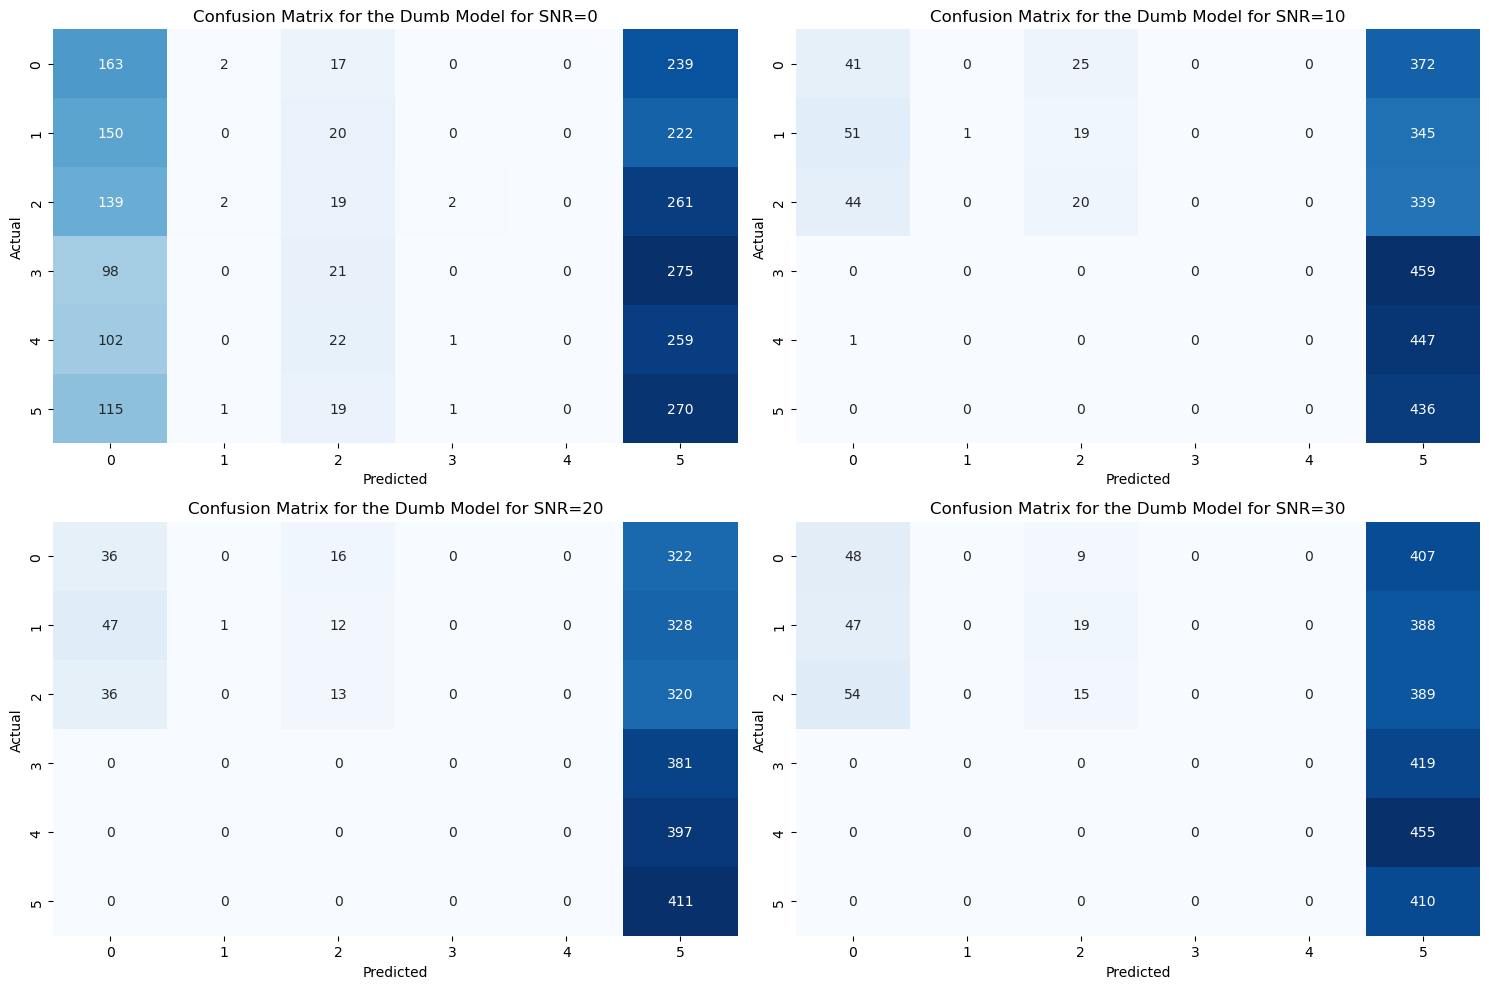

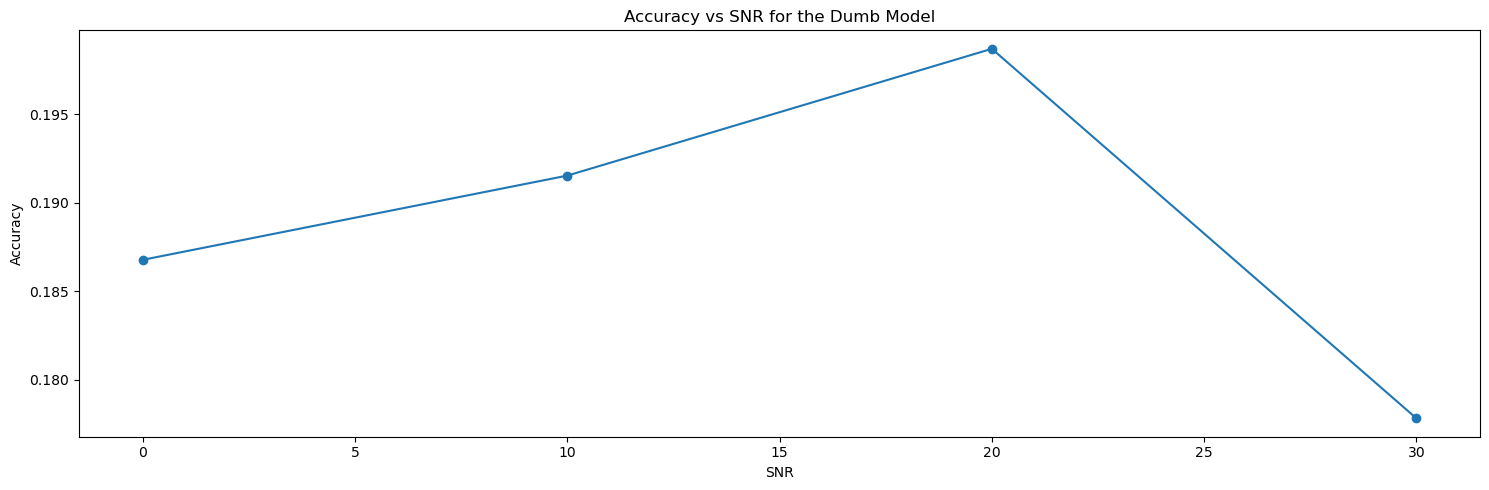

In [114]:
model_dncnn = torch.load("dncnn_model.pt")
test_pipeline(model_dncnn)

On a rapidement tester d'appliquer cette méthode en rajouter un Denoising Auto-Encoder avant le CNN qui s'occupe de déconstruire le signal bruité puis le reconstruire avec moins de bruit. Le cas échéant les résultats ne sont pas du tout concluant puisqu'ils sont pires que ceux obtenus avec le CNN seul. Cela peut s'expliquer par le fait que le Denoising Auto-Encoder n'est pas assez performant pour débruiter le signal et donc il introduit plus de bruit que ce qu'il enlève. Il faudrait donc trouver un modèle plus performant pour la tâche de débruitage.